### <b>reproduce FLH retrieval for OCI</b>
2025-08-11, Zichang

I got the same nFLH result as OCI L2 product! Some discrepancies might come from using nominal band wavelength rather than true wavelength when fitting the baseline spectrum.

In the code below I took a random granule and compare my retrieval with the L2 nFLH data. Both unit and magnitude are consistent!

In [1]:
import numpy as np
import xarray as xr
# import dask.array as da
# from dask.distributed import Client, LocalCluster

import earthaccess
from functools import partial
import statsmodels.api as sm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

auth = earthaccess.login()

In [2]:
# select a granule for testing
num_of_chunks = 10
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240718T161154.L1B.V3.nc"]
)

# L2 data
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240718T161154.L2.OC_AOP.V3_0.nc"]
)
# name2 = "/home/zhe2/data/PACE/L2_AOP/PACE_OCI.20250130T204559.L2.OC_AOP.V3_0.nc"
datatree2 = xr.open_datatree(granule[0])
ds2 = xr.merge(datatree2.to_dict().values())
ds2

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1709,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/32)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    avw            (number_of_lines, pixels_per_line) float32 9MB ...
    nflh           (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20240718T161154.L2.OC_AOP.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data6/sdpsoper/vdc/vpu5/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -38.259632
    geospatial_lon_min:                -73.112144
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9682631492614746

In [3]:
# subset ds2 to: 1) select some variables; 2) align wavelength range!
wavelength_3d = ds2.wavelength_3d.values
wavelength    = ds2.wavelength.values
index         = np.isin(wavelength, wavelength_3d)
ds2_sub       = ds2.isel(number_of_bands=index, number_of_reflective_bands=index)

# squeeze
ds2_sub = ds2_sub.rename({'number_of_bands': 'wavelength_3d', 
                'number_of_reflective_bands': 'wavelength_3d'
                }).squeeze()

print("squeezed!")
# chunk
ds2_chunk = ds2_sub#.chunk({'number_of_lines': 100})

squeezed!


#### <b>Water leaving radiance (W/m2/µm/sr)</b>

ref: https://www.earthdata.nasa.gov/apt/documents/rrs/v1.1#output_variables

Normalized water leaving radiance is calculated from:
$$L_{WN}=R_{rs}\times F_0$$

In [4]:
nLw = ds2_chunk.Rrs * ds2_chunk.F0

In [5]:
ds2_chunk["nLw"] = xr.DataArray(
    nLw,    
    dims  = ['number_of_lines', 'pixels_per_line', 'wavelength_3d'],
    attrs = {
        'long_name': "normalized water leaving radiance",
        'units':"W/m2/µm/sr"
    }
)
ds2_chunk = ds2_chunk.set_coords(("longitude", "latitude"))

### <b>Case study - choose a pixel</b>

In [6]:
np.argwhere((ds2_chunk.nflh.values>=.4) & (ds2_chunk.nflh.values<=.5))

array([[721,  50],
       [762, 110],
       [763, 109],
       [848, 182]])

In [7]:
ds2_chunk.Rrs

<xarray.DataArray 'Rrs' (number_of_lines: 1709, pixels_per_line: 1272,
                         wavelength_3d: 172)> Size: 1GB
[373901856 values with dtype=float32]
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000

Text(0.5, 0.98, 'select: number_of_lines=762, px_per_line=110')

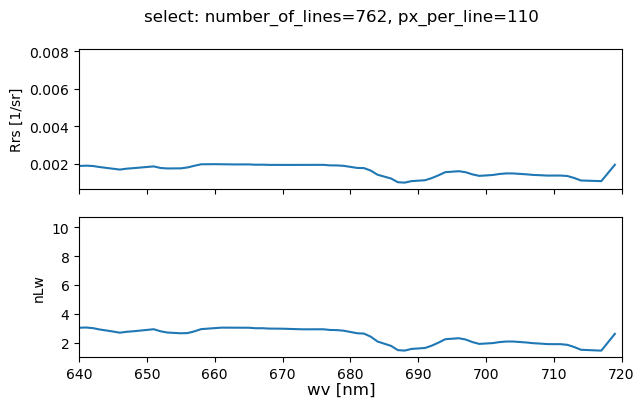

In [25]:
# vis.
lines = 762
px    = 110
Rrs_sp = ds2_chunk.Rrs.isel(number_of_lines=lines, pixels_per_line=px)
nLw_sp = ds2_chunk.nLw.isel(number_of_lines=lines, pixels_per_line=px)
fig, ax = plt.subplots(2, 1, figsize=(7,4), sharex=True)
ax[0].plot(wavelength_3d, Rrs_sp)
ax[1].plot(wavelength_3d, nLw_sp)
ax[1].set_xlim(640, 720)
fig.supxlabel("wv [nm]")
ax[0].set_ylabel("Rrs [1/sr]")
ax[1].set_ylabel("nLw")
fig.suptitle(f"select: number_of_lines={lines}, px_per_line={px}")

In [9]:
def find_nearest(arr, trg):
    idx = [np.argmin(np.abs(arr - i)) for i in trg]
    return idx

def linear_fit(wavlen, ydata):
    # add constants & fit
    X = sm.add_constant(wavlen)
    mod = sm.OLS(ydata, X)
    res = mod.fit()
    # get fitting results
    c0, c1 = res.params
    cov00, cov01, _, cov11 = res.cov_params().flatten()
    return c0, c1, cov00, cov01, cov11

In [27]:
# baseline wavelengths
base_wv = np.array([649.599976, 650.900024, 652.099976, 653.299988,
                    654.599976, 655.799988, 657.099976, 658.299988,
                    659.599976, 710.500000, 711.799988, 713.000000,
                    714.299988, 716.799988, 719.200012])
# base_wv = np.array([649.599976, 650.900024, 652.099976, 653.299988,
#                     654.599976, 655.799988, 657.099976, 658.299988,
#                     659.599976, 710.500000, 711.799988, 713.000000,
#                     714.299988, 716.799988])
fluo_wv = 678.20001
# mask_bl = find_nearest(wavelength3d.values, base_wv)
mask_bl  = find_nearest(wavelength_3d, base_wv)
print(wavelength_3d[mask_bl])
y_sample = nLw_sp.values

[650. 651. 652. 653. 655. 656. 657. 658. 660. 711. 712. 713. 714. 717.
 719.]


In [28]:
c0, c1, _, _, _ = linear_fit(wavelength_3d[mask_bl], y_sample[mask_bl])
bl_sp   = c0 + c1 * wavelength_3d
mask_fl = find_nearest(wavelength_3d, [fluo_wv])
nflh_sp = y_sample[mask_fl] - bl_sp[mask_fl]
print(f"retrieved fluorescence line height = {nflh_sp} W/m2/µm/sr")

retrieved fluorescence line height = [0.43732092] W/m2/µm/sr


In [29]:
nflh_ref = ds2_chunk.nflh.isel(number_of_lines=lines, pixels_per_line=px).values
print(f"product fluorescence line height = {nflh_ref}")

product fluorescence line height = 0.4405200481414795


Text(0.5, 0.98, 'select: number_of_lines=762, px_per_line=110')

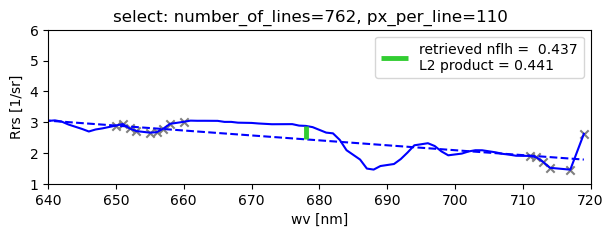

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7,2), sharex=True)
ax.plot(wavelength_3d, y_sample, "b")
ax.scatter(wavelength_3d[mask_bl], y_sample[mask_bl], c="grey", marker="x")
ax.plot(wavelength_3d, bl_sp, "b--")
ax.vlines(wavelength_3d[mask_fl], bl_sp[mask_fl], y_sample[mask_fl],
          linewidth=3.5, color="limegreen",
          label=f"retrieved nflh = {nflh_sp[0]: .3f}\nL2 product = {nflh_ref:.3f}"
          )

ax.set_xlim(640, 720)
ax.set_ylim(1, 6)
ax.set_xlabel("wv [nm]")
ax.set_ylabel("Rrs [1/sr]")
ax.legend()
fig.suptitle(f"select: number_of_lines={lines}, px_per_line={px}")

### <b>Apply to the whole scene</b>

In [14]:
from functools import partial

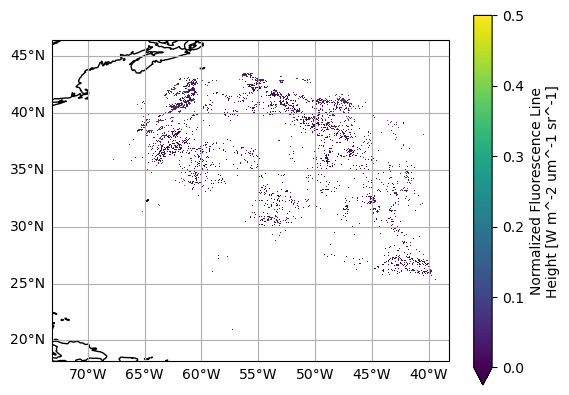

In [15]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = ds2_chunk["nflh"].plot(
    x="longitude", y="latitude", cmap="viridis", vmin=0, vmax=.5, ax=ax
)

In [16]:
def nflh_oci(nLw_arr, mark, wv_arr, baseline_wv, fluo_wv):
    if not (mark==mark):
        return np.nan
    c0, c1, _, _, _ = linear_fit(wv_arr[baseline_wv], nLw_arr[baseline_wv])
    # baseline
    baseline_spec = c0 + c1 * wv_arr
    # line height
    fluo_line_height = nLw_arr[fluo_wv] - baseline_spec[fluo_wv]
    # return
    return fluo_line_height[0]


In [17]:
nflh_func = partial(nflh_oci, wv_arr=wavelength_3d, baseline_wv=np.array(mask_bl), fluo_wv=np.array(mask_fl))


In [18]:
# Create a local cluster with a specific number of workers and threads
# cluster = LocalCluster(n_workers=4, threads_per_worker=1)

# Connect a Dask client to the cluster
# client = Client(cluster)

In [19]:
result_lazy = xr.apply_ufunc(
    nflh_func,
    ds2_chunk.nLw,
    ds2_chunk.nflh,
    input_core_dims=[['wavelength_3d'],[]], # compute over wavelength_3d
    output_core_dims=[[]],    # the output contains no wavelength_3d dim
    # dask='parallelized',
    output_dtypes=[float],
    vectorize=True,
)


In [20]:
result_lazy

<xarray.DataArray (number_of_lines: 1709, pixels_per_line: 1272)> Size: 17MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(1709, 1272))
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 9MB -63.5 ... -40.46
    latitude   (number_of_lines, pixels_per_line) float32 9MB 18.22 ... 46.46
Dimensions without coordinates: number_of_lines, pixels_per_line

Text(0.5, 1.0, 'retrieved nFLH')

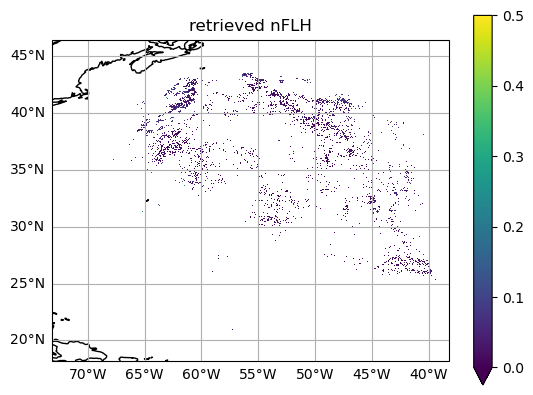

In [21]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
result_lazy.plot(
    x="longitude", y="latitude", cmap="viridis", vmin=0, vmax=.5, ax=ax
)
ax.set_title("retrieved nFLH")

In [22]:
# client.close()
# cluster.close()

### <b>Scatter plot</b>

In [23]:
from scipy.stats import gaussian_kde

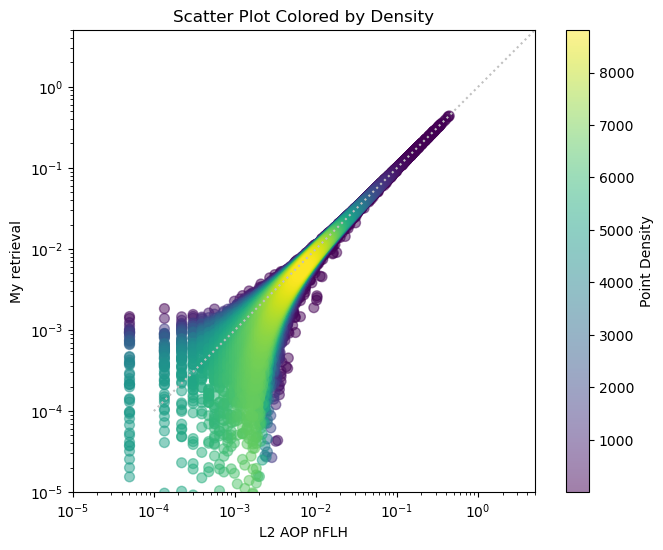

In [34]:
# 1. Generate some sample data
x = ds2_chunk["nflh"].values
y = result_lazy.values
ind = (x==x) & (y==y)
x = x[ind]
y = y[ind]

# 2. Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# 3. Sort points by density to ensure the densest points are on top
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# 4. Create the scatter plot, using 'z' for coloring
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, c=z, s=50, cmap='viridis', alpha=.5)
ax.plot([1E-4, 10], [1E-4, 10], ":", color="silver")

# Customize the plot
min_val = 1E-5 # max(1E-5, x.min(), y.min())
max_val = 5 # min(1,    x.max(), y.max())
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_title('Scatter Plot Colored by Density')
ax.set_xlabel('L2 AOP nFLH')
ax.set_ylabel('My retrieval')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal', adjustable='box')
cbar = fig.colorbar(ax.collections[0])
cbar.set_label('Point Density')
plt.show()